![QuantConnect Logo](https://cdn.quantconnect.com/web/i/icon.png)
<hr>

<Axes: >

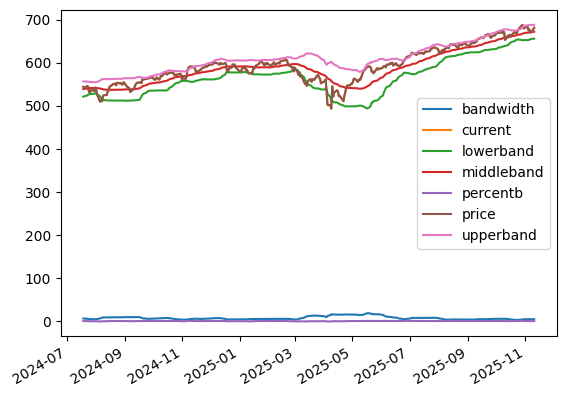

In [25]:
# QuantBook Analysis Tool 
# For more information see [https://www.quantconnect.com/docs/v2/our-platform/research/getting-started]
qb = QuantBook()
spy = qb.AddEquity("SPY")
history = qb.History(qb.Securities.Keys, 360, Resolution.Daily)

# Indicator Analysis
bbdf = qb.Indicator(BollingerBands(30, 2), spy.Symbol, 360, Resolution.Daily)
bbdf.drop('standarddeviation', axis=1).plot()

In [26]:
# Core
import pandas as pd, numpy as np
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

# Metrics
def dd_curve(equity):
    peak = equity.cummax()
    return (equity/peak - 1.0)

def ann_return(returns, periods_per_year=252):
    g = (1.0 + returns).prod()
    n = len(returns)
    return g**(periods_per_year/max(1,n)) - 1.0

def ann_vol(returns, periods_per_year=252):
    return returns.std(ddof=0) * np.sqrt(periods_per_year)

def sharpe(returns, rf=0.0, periods_per_year=252):
    ex = returns - rf/periods_per_year
    vol = ann_vol(ex, periods_per_year)
    return (ex.mean()*periods_per_year)/vol if vol>0 else np.nan


Set research params

In [27]:
START = pd.Timestamp('2016-01-01', tz='America/New_York')
END   = pd.Timestamp('2025-10-31', tz='America/New_York')

COARSE_SIZE   = 1000     # liquidity cut
FINE_SIZE     = 250      # candidates with valid PB
PORTFOLIO_N   = 100      # final picks (cheapest PB)
PRICE_FLOOR   = 5.0
ADV_FLOOR     = 5e6      # DollarVolume
MCAP_FLOOR    = 1e9
FEE_BPS       = 0.5      # per side, 50 bps round-trip by default stress
SLIP_BPS      = 5        # per side
REBAL_FREQ    = 'M'      # monthly

np.seterr(all='ignore')


{'divide': 'ignore', 'over': 'ignore', 'under': 'ignore', 'invalid': 'ignore'}

In [28]:
def month_ends(start, end):
    d = pd.Timestamp(start).normalize()
    out = []
    while d <= end:
        month_end = (d + relativedelta(day=31)).normalize()
        if month_end >= start and month_end <= end:
            out.append(month_end)
        d = d + relativedelta(months=1, day=1)
    return pd.DatetimeIndex(out).tz_convert('America/New_York')

SCHEDULE = month_ends(START, END)
SCHEDULE[:5], SCHEDULE[-5:]


(DatetimeIndex(['2016-01-31 00:00:00-05:00', '2016-02-29 00:00:00-05:00',
                '2016-03-31 00:00:00-04:00', '2016-04-30 00:00:00-04:00',
                '2016-05-31 00:00:00-04:00'],
               dtype='datetime64[ns, America/New_York]', freq=None),
 DatetimeIndex(['2025-06-30 00:00:00-04:00', '2025-07-31 00:00:00-04:00',
                '2025-08-31 00:00:00-04:00', '2025-09-30 00:00:00-04:00',
                '2025-10-31 00:00:00-04:00'],
               dtype='datetime64[ns, America/New_York]', freq=None))

In [49]:
from QuantConnect.Research import QuantBook
qb = qb if 'qb' in globals() else QuantBook()

def to_ticker(x):  # Symbol or str -> ticker str
    return x.Value if hasattr(x, "Value") else str(x)

def to_symbol(x):  # Symbol or str -> Symbol
    return x if hasattr(x, "ID") else qb.AddEquity(str(x), Resolution.Daily).Symbol


In [51]:
# === Coarse/Fine without qb.get_coarse_fundamental ===
from QuantConnect.Research import QuantBook
qb = qb if 'qb' in globals() else QuantBook()

import pandas as pd, numpy as np
from dateutil.relativedelta import relativedelta

def _last_snapshot(df: pd.DataFrame, as_of):
    """
    Forward-fill fundamentals to the as-of timestamp and take the last row.
    Handles tz-aware/naive mismatches robustly.
    """
    if df is None or df.empty:
        return pd.Series(dtype=float)

    # Work on a copy to avoid mutating upstream frames
    snap_df = df.copy()

    # Normalize index to tz-naive
    idx = pd.DatetimeIndex(snap_df.index)
    if idx.tz is not None:
        # convert to naive by dropping tz
        snap_df.index = idx.tz_convert(None)
    else:
        snap_df.index = idx  # already naive

    # Normalize as_of to tz-naive
    as_of_ts = pd.Timestamp(as_of)
    if as_of_ts.tz is not None:
        as_of_ts = as_of_ts.tz_convert(None)

    # Forward-fill and cut at as-of
    snap_df = snap_df.sort_index().ffill()
    snap_df = snap_df.loc[:as_of_ts]
    if snap_df.empty:
        return pd.Series(dtype=float)

    return snap_df.iloc[-1]

def _to_symbol(obj):
    if hasattr(obj, "ID"):
        return obj
    return qb.AddEquity(str(obj), Resolution.Daily).Symbol

def select_coarse(date):
    """
    Coarse via MarketCap as-of date using only `prices` columns.
    Returns: list[str] tickers present in prices.columns
    """
    if 'prices' not in globals() or prices.empty:
        return []

    # align `date` to prices index
    idx = prices.index
    d = pd.Timestamp(date)
    if d.tzinfo and idx.tz is None:
        d = d.tz_convert(None)
    if d not in idx:
        pos = idx.searchsorted(d)
        if pos == 0:
            return []
        d = idx[min(pos, len(idx)-1)]

    last_px = prices.ffill().loc[d]
    tickers = list(prices.columns)
    symbols = [to_symbol(t) for t in tickers]

    start = (pd.Timestamp(d) - relativedelta(months=24)).to_pydatetime()
    end   = pd.Timestamp(d).to_pydatetime()
    df_mcap = qb.GetFundamental(symbols, "MarketCap", start, end)
    mcap = pd.to_numeric(_last_snapshot(df_mcap, end), errors="coerce").replace([np.inf, -np.inf], np.nan)

    # map fundamentals index (Symbol) -> ticker
    if not mcap.empty and hasattr(mcap.index[0], "Value"):
        mcap.index = [s.Value for s in mcap.index]

    common = mcap.index.intersection(last_px.index.astype(str))
    if len(common) == 0:
        return []

    mcap = mcap.loc[common]
    px   = last_px.loc[common]
    good = px.ge(PRICE_FLOOR) & mcap.notna() & (mcap > 0)

    ranked = mcap[good].sort_values(ascending=False).head(COARSE_SIZE)
    return list(ranked.index)


def select_fine(date, coarse_tickers):
    """
    Fine on fundamentals as-of date; input/output are ticker strings.
    """
    if not coarse_tickers:
        return []

    symbols = [to_symbol(t) for t in coarse_tickers]
    start = (pd.Timestamp(date) - relativedelta(months=24)).to_pydatetime()
    end   = pd.Timestamp(date).to_pydatetime()

    df_pb   = qb.GetFundamental(symbols, "ValuationRatios.PBRatio", start, end)
    df_mcap = qb.GetFundamental(symbols, "MarketCap", start, end)
    df_exch = qb.GetFundamental(symbols, "CompanyReference.PrimaryExchangeID", start, end)
    df_adr  = qb.GetFundamental(symbols, "SecurityReference.IsDepositaryReceipt", start, end)

    pb   = pd.to_numeric(_last_snapshot(df_pb,   end), errors="coerce")
    mcap = pd.to_numeric(_last_snapshot(df_mcap, end), errors="coerce")
    exch = _last_snapshot(df_exch, end)
    adr  = _last_snapshot(df_adr,  end)

    # index → ticker strings
    def idx_to_ticker(s):
        if s is None or s.empty: return s
        if hasattr(s.index[0], "Value"):
            s.index = [x.Value for x in s.index]
        return s

    pb   = idx_to_ticker(pb)
    mcap = idx_to_ticker(mcap)
    exch = idx_to_ticker(exch)
    adr  = idx_to_ticker(adr)

    idx = pb.index.intersection(mcap.index)
    if len(idx) == 0:
        return []

    pb, mcap = pb.loc[idx], mcap.loc[idx]
    exch = exch.reindex(idx)
    adr  = adr.reindex(idx)

    good = (
        pb.replace([np.inf, -np.inf], np.nan).gt(0) &
        mcap.replace([np.inf, -np.inf], np.nan).ge(MCAP_FLOOR) &
        adr.fillna(False).eq(False) &
        exch.fillna("").ne("OTC")
    )

    return list(pb[good].sort_values(ascending=True).head(FINE_SIZE).index)



Price loader

In [48]:
def load_prices(universe, start, end):
    from QuantConnect.Research import QuantBook
    qb = qb if 'qb' in globals() else QuantBook()
    if not universe:
        return pd.DataFrame()

    # normalize input to tickers
    tickers = [s.Value if hasattr(s, "Value") else str(s) for s in universe]
    symbols = [qb.AddEquity(t, Resolution.Daily).Symbol for t in tickers]

    hist = qb.History(symbols, start, end, Resolution.Daily)
    if hist.empty:
        return pd.DataFrame()

    closes = hist["close"].unstack(level=0)
    # rename columns → ticker strings
    colmap = {sym: sym.Value for sym in symbols}
    closes = closes.rename(columns=colmap)
    closes = closes.tz_localize('America/New_York').dropna(how="all")
    return closes


In [31]:
# Example test
test_symbols = ["AAPL", "MSFT", "GOOG", "AMZN"]
prices = load_prices(test_symbols, START, END)
prices.head()


symbol,AAPL,AMZN,GOOG,MSFT
time,,,,
2016-01-04 16:00:00-05:00,23.723206,31.774781,36.839893,48.073273
2016-01-05 16:00:00-05:00,23.128718,31.615156,36.876642,48.292585
2016-01-06 16:00:00-05:00,22.676097,31.558290,36.928288,47.415335
2016-01-07 16:00:00-05:00,21.719062,30.325689,36.072644,45.766106
2016-01-08 16:00:00-05:00,21.833906,30.281293,35.480695,45.906466


PB snapshot loader (point-in-time)

In [ ]:
def load_pb_snapshot(symbols_or_tickers, date, months_back=24):
    if not symbols_or_tickers:
        return pd.Series(dtype=float)

    symbols = [to_symbol(s) for s in symbols_or_tickers]
    start = (pd.Timestamp(date) - relativedelta(months=months_back)).to_pydatetime()
    end   = pd.Timestamp(date).to_pydatetime()

    df = qb.GetFundamental(symbols, "ValuationRatios.PBRatio", start, end)
    s = pd.to_numeric(_last_snapshot(df, end), errors="coerce").replace([np.inf, -np.inf], np.nan)
    s = s[s > 0].dropna()
    if not s.empty and hasattr(s.index[0], "Value"):
        s.index = [x.Value for x in s.index]  # tickers
    return s.astype(float)


Portfolio formation: cheapest PB

In [53]:
def form_portfolio(date, prices, candidates):
    pb = load_pb_snapshot(candidates, date)
    pb = pb.sort_values().head(PORTFOLIO_N)
    return list(pb.index)



In [41]:
# --- Helpers: alignment & symbol normalization ---
from QuantConnect.Research import QuantBook
qb = qb if 'qb' in globals() else QuantBook()
import pandas as pd, numpy as np

def _to_symbol(obj):
    # Normalize to QC Symbol
    if hasattr(obj, "ID"): return obj
    sym = qb.AddEquity(str(obj), Resolution.Daily).Symbol
    return sym

def _align_date_to_prices(dt, idx: pd.DatetimeIndex):
    # Return the first index >= dt; if beyond, return last; if before all, return None
    dt = pd.Timestamp(dt)
    if idx.tz is not None and dt.tz is None:
        dt = dt.tz_localize(idx.tz)
    elif idx.tz is None and dt.tz is not None:
        dt = dt.tz_convert(None)
    pos = idx.searchsorted(dt)
    if pos >= len(idx): return idx[-1]
    return idx[pos]

def _last_trading_before_or_equal(dt, idx: pd.DatetimeIndex):
    dt = pd.Timestamp(dt)
    if idx.tz is not None and dt.tz is None:
        dt = dt.tz_localize(idx.tz)
    elif idx.tz is None and dt.tz is not None:
        dt = dt.tz_convert(None)
    pos = idx.searchsorted(dt, side="right") - 1
    if pos < 0: return None
    return idx[pos]


In [54]:
def simulate_equal_weight(prices, schedule, fee_bps=FEE_BPS, slip_bps=SLIP_BPS, log_first_n=3):
    idx = prices.index
    daily_ret = prices.pct_change().fillna(0.0)

    portfolio_w = pd.DataFrame(0.0, index=idx, columns=prices.columns)
    equity = pd.Series(index=idx, dtype=float); equity.iloc[0] = 1.0

    fee_per_side = fee_bps/1e4
    slip_per_side = slip_bps/1e4
    tc_per_turn = fee_per_side + slip_per_side

    anchors = pd.DatetimeIndex(sorted(set(_align_date_to_prices(d, idx) for d in schedule)))
    anchors = anchors.dropna()
    prev_weights = pd.Series(0.0, index=prices.columns)
    logs_done = 0

    for i, a in enumerate(anchors):
        period_end = anchors[i+1] if i+1 < len(anchors) else idx[-1]
        start_bar = idx.get_loc(a)
        if start_bar >= len(idx)-1:
            continue
        trade_bar = idx[start_bar+1]
        end_bar = _last_trading_before_or_equal(period_end, idx)
        if end_bar is None or trade_bar > end_bar:
            continue

        coarse = select_coarse(a)              # tickers
        fine   = select_fine(a, coarse)        # tickers
        picks  = form_portfolio(a, prices, fine)  # tickers
        picks  = [p for p in picks if p in prices.columns]

        if logs_done < log_first_n:
            print(f"[{str(a)[:10]}] coarse={len(coarse)} fine={len(fine)} picks={len(picks)}")
            if picks:
                print("  sample picks:", picks[:5])
            logs_done += 1

        if not picks:
            target_w = pd.Series(0.0, index=prices.columns)
        else:
            w = 1.0/len(picks)
            target_w = pd.Series(0.0, index=prices.columns); target_w.loc[picks] = w

        turnover = (target_w - prev_weights).abs().sum()
        equity.loc[trade_bar] = (equity.loc[idx[start_bar]] if pd.notna(equity.loc[idx[start_bar]]) else equity.ffill().iloc[start_bar]) * (1 - turnover*tc_per_turn)

        portfolio_w.loc[trade_bar:end_bar, :] = 0.0
        if picks:
            for t in picks:
                portfolio_w.loc[trade_bar:end_bar, t] = w

        prev_weights = target_w

    equity = equity.ffill()
    port_ret = (portfolio_w * daily_ret).sum(axis=1)
    equity = (1.0 + port_ret).cumprod()
    dds = (equity / equity.cummax() - 1.0)
    return port_ret, equity, dds, portfolio_w


In [35]:
# === 8) RUN (revised master universe without GetCoarse) ===
from QuantConnect.Research import QuantBook
qb = qb if 'qb' in globals() else QuantBook()

def _etf_constituents(ticker: str, date):
    # SPY (S&P 500) + IWM (Russell 2000) give a broad US universe
    try:
        cons = qb.GetETFConstituents(ticker, date)  # returns list of Constituents with .Symbol
        return [c.Symbol for c in cons] if cons else []
    except AttributeError:
        return []  # older kernels may not have this helper

def get_liquid_universe(size=1500, date=END.normalize(), adv_lookback=60, min_price=5.0):
    # 1) Seed symbols from broad ETFs (S&P500 + Russell 2000). De-duplicate.
    seed_syms = list({* _etf_constituents("SPY", date), * _etf_constituents("IWM", date)})
    if not seed_syms:
        # Fallback: a conservative mega-cap basket if ETF constituents API unavailable
        fallback = ["AAPL","MSFT","AMZN","GOOGL","NVDA","META","BRK.B","XOM","JNJ","UNH","JPM","V","PG","MA","HD","AVGO","CVX","PEP","PFE","KO"]
        seed_syms = [qb.AddEquity(t, Resolution.Daily).Symbol for t in fallback]
    else:
        # Ensure added to QuantBook
        seed_syms = [qb.AddEquity(s.ID.Symbol, Resolution.Daily).Symbol for s in seed_syms]

    # 2) Compute Average Dollar Volume (ADV) over `adv_lookback` trading days
    hist = qb.History(seed_syms, date - timedelta(days=adv_lookback*2), date, Resolution.Daily)
    if hist.empty:
        return seed_syms  # fallback

    closes = hist["close"].unstack(level=0)
    vols   = hist["volume"].unstack(level=0)

    # Align and compute ADV
    common_cols = closes.columns.intersection(vols.columns)
    closes = closes[common_cols]
    vols   = vols[common_cols]

    adv = (closes * vols).rolling(adv_lookback, min_periods=adv_lookback//2).mean().iloc[-1]
    last_px = closes.iloc[-1]

    mask = last_px.ge(min_price) & adv.notna()
    adv = adv[mask].sort_values(ascending=False)

    # 3) Take top-N liquid names
    selected = list(adv.head(size).index)
    return selected

master_symbols = get_liquid_universe(1500, date=END.normalize(), adv_lookback=60, min_price=5.0)
print(f"Universe size: {len(master_symbols)} symbols")

# --- Step 2: load price data (close only) ---
prices = load_prices(master_symbols, START, END)
print(f"Price matrix shape: {prices.shape}")

# Quick sanity peek
prices.iloc[:, :5].tail()


Universe size: 20 symbols
Price matrix shape: (2472, 20)


symbol,AAPL,AMZN,AVGO,BRK.B,CVX
time,,,,,
2025-10-24 16:00:00-04:00,262.565459,224.21,354.13,492.12,155.56
2025-10-27 16:00:00-04:00,268.549658,226.97,362.05,488.07,155.28
2025-10-28 16:00:00-04:00,268.739473,229.25,372.97,481.46,154.13
2025-10-29 16:00:00-04:00,269.438796,230.30,385.98,475.76,155.16
2025-10-30 16:00:00-04:00,271.137149,222.86,376.47,478.52,153.51


In [55]:
port_ret, equity, dds, weights = simulate_equal_weight(
    prices,
    SCHEDULE,
    fee_bps=FEE_BPS,
    slip_bps=SLIP_BPS
)

pd.Series({
    "CAGR": ann_return(port_ret),
    "Vol": ann_vol(port_ret),
    "Sharpe": sharpe(port_ret),
    "MaxDD": dds.min(),
    "Turnover/mo": weights.diff().abs().sum(axis=1).resample('ME').sum().mean(),
})


[2016-02-01] coarse=0 fine=0 picks=0
[2016-02-29] coarse=0 fine=0 picks=0
[2016-03-31] coarse=0 fine=0 picks=0


CAGR           0.0
Vol            0.0
Sharpe         NaN
MaxDD          0.0
Turnover/mo    0.0
dtype: float64